## Carefull, very much work in progress
Currently, uses a single items sell,buy, sellvol,buyvol to predict.
This may not work
Other ideas:
Using multiple items

Uses min-max scaler, may not be working correctly.

In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import mlflow
from darts.models import VARIMA
import pandas as pd
import numpy as np
import matplotlib

In [3]:
# Download source data from s3
from ml.common.folder_s3_sync import download_folder_from_s3

datapath = "../../../data/train_vectorarima/"


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1762686861', local_folder=datapath)
df = pd.read_csv(f'{datapath}Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1762686861
Target: ../../../data/train_vectorarima/

Found 60 files to download

⊘ +1 Agony Infusion.csv (already exists, ETag matches)
⊘ Auric Sliver.csv (already exists, ETag matches)
⊘ Bag of Coffee Beans.csv (already exists, ETag matches)
⊘ Bag of Sugar.csv (already exists, ETag matches)
⊘ Black Lion Chest.csv (already exists, ETag matches)
⊘ Bowl of Candy Corn Custard.csv (already exists, ETag matches)
⊘ Choya Spine.csv (already exists, ETag matches)
⊘ Congealed Putrescence.csv (already exists, ETag matches)
⊘ Copper Ore.csv (already exists, ETag matches)
⊘ Cup of Spiced Apple Cider.csv (already exists, ETag matches)
⊘ Elder Wood Log.csv (already exists, ETag matches)
⊘ Eye of Kormir.csv (already exists, ETag matches)
⊘ Flawless Snowflake.csv (already exists, ETag matches)
⊘ Fried Golden Dumpling.csv (already exists, ETag matches)
⊘ Glass of Buttered Spirits.csv (already exists, ETag matches)
⊘ Glob of Ectoplasm.csv (already exists, ETag matches)

<Axes: xlabel='fetched_at'>

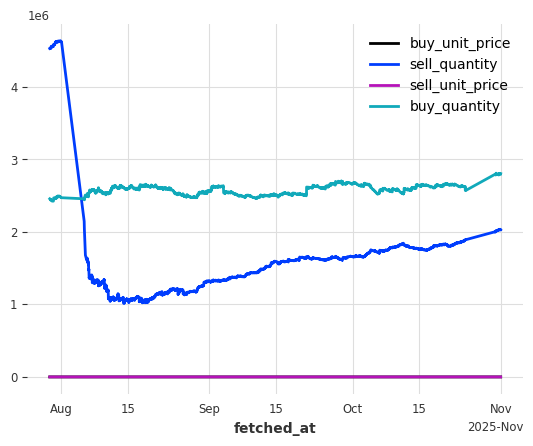

In [4]:
from darts import TimeSeries
value_cols = ["buy_unit_price","sell_quantity", "sell_unit_price", "buy_quantity"]

#value_cols = ["buy_unit_price","sell_unit_price"]

tsdf = df[value_cols + ['fetched_at']].copy()
# series = TimeSeries.from_dataframe(df, time_col="fetched_at")

# Convert to datetime and set as index
tsdf['fetched_at'] = pd.to_datetime(tsdf['fetched_at'])
# Localize timezone to UTC if it has timezone info, or remove it
if tsdf['fetched_at'].dt.tz is not None:
    tsdf['fetched_at'] = tsdf['fetched_at'].dt.tz_localize(None)
tsdf = tsdf.set_index('fetched_at')

# Resample to exact 5-minute intervals, forward-filling missing values
tsdf_resampled = tsdf[value_cols].resample('5min').mean().interpolate(method='linear')

# Create TimeSeries (no need for fill_missing_dates now)
series = TimeSeries.from_dataframe(tsdf_resampled, value_cols=value_cols)
#series.plot();
series.plot()

<Axes: xlabel='fetched_at'>

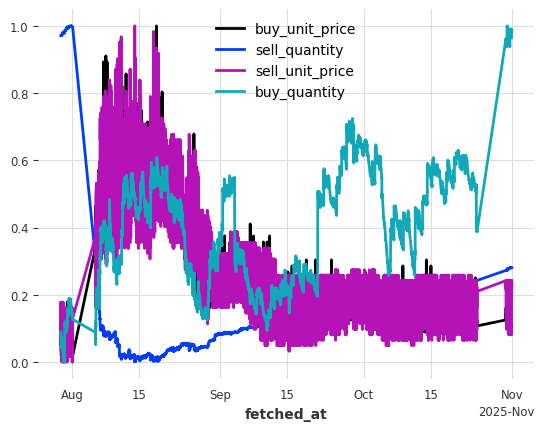

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Scaling the data
from darts.dataprocessing.transformers import Scaler
scaler = Scaler(scaler=MinMaxScaler())
series_scaled = scaler.fit_transform(series)
series_scaled.plot()

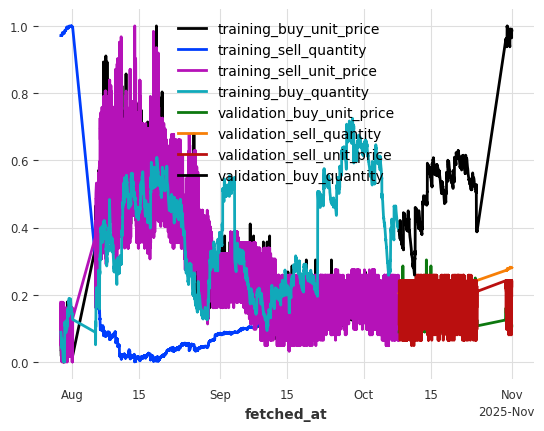

In [6]:
train, val = series_scaled.split_after(0.75)
train.plot(label="training")
val.plot(label="validation");


In [7]:
from darts.metrics import mape
from darts.models import VARIMA

model = VARIMA()
model.fit(train, verbose=True)
forecast = model.predict(len(val))
error = mape(val, forecast)
print(f"MAPE: {error:.2f}%")


MAPE: 53.31%


<Axes: xlabel='fetched_at'>

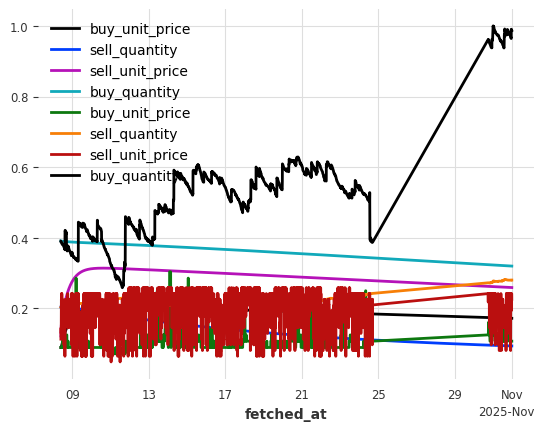

In [8]:
forecast.plot()
val.plot()

In [9]:
import mlflow
import os

mlflow.set_experiment("VectorArima")
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

2025/11/18 15:30:31 INFO mlflow.tracking.fluent: Experiment with name 'VectorArima' does not exist. Creating a new experiment.


MLflow Tracking URI: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000


In [10]:
from darts.metrics import mape
from darts.models import VARIMA
from tqdm.notebook import tqdm
import mlflow
import os

print(mlflow.get_tracking_uri())


best_mape = float('inf')
best_params = None

# Parent run for the hyperparameter search
with mlflow.start_run(run_name="VARIMA_Hyperparameter_Search"):

    # Log search configuration
    mlflow.log_param("search_p_range", "0-3")
    mlflow.log_param("search_d_range", "0-1")
    mlflow.log_param("search_q_range", "0-3")
    mlflow.log_param("total_combinations", sum(1 for p in range(0,4) for d in range(0,2) for q in range(0,4) if not (p==0 and q==0)))

    # Create progress bar
    for p in range(0, 4):
        for d in range(0, 2):
            for q in range(0, 4):
                # Skip invalid combinations where both p and q are 0
                if p == 0 and q == 0:
                    continue

                print(f"Testing VARIMA({p},{d},{q})")

                # Child run for each parameter combination
                with mlflow.start_run(run_name=f"VARIMA_{p}_{d}_{q}", nested=True):
                    # Log parameters
                    mlflow.log_param("p", p)
                    mlflow.log_param("d", d)
                    mlflow.log_param("q", q)
                    mlflow.log_param("model_type", "VARIMA")

                    try:
                        # Train model
                        model = VARIMA(p=p, d=d, q=q)
                        model.fit(train)

                        # Make predictions
                        forecast = model.predict(len(val))
                        error = mape(val, forecast)

                        # Log metrics
                        mlflow.log_metric("mape", error)
                        mlflow.log_metric("mape_percentage", error)

                        # Log model artifact
                        mlflow.sklearn.log_model(model, "model")

                        # Check if this is the best model so far
                        if error < best_mape:
                            best_mape = error
                            best_params = (p, d, q)
                            print(f"New best: VARIMA{best_params} with MAPE: {error:.2f}%")

                            # Log as best model in parent run
                            mlflow.log_metric("best_mape", error)
                            mlflow.log_param("best_p", p)
                            mlflow.log_param("best_d", d)
                            mlflow.log_param("best_q", q)

                    except Exception as e:
                        # Log failed runs
                        mlflow.log_param("status", "failed")
                        mlflow.log_param("error", str(e))
                        print(f"Failed VARIMA({p},{d},{q}): {str(e)}")

    # Log final results in parent run
    mlflow.log_metric("final_best_mape", best_mape)
    mlflow.log_param("final_best_params", str(best_params))

    print(f"\nBest model: VARIMA{best_params} with MAPE: {best_mape:.2f}%")


http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000
Testing VARIMA(0,0,1)


/home/lukas/Documents/Github/casml4se-stonkswagen/notebooks/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025/11/18 15:31:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/18 15:31:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/18 15:31:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


New best: VARIMA(0, 0, 1) with MAPE: 100.00%
🏃 View run VARIMA_0_0_1 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2/runs/6693c094b8154564aba01bb79b465e11
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2
Testing VARIMA(0,0,2)


/home/lukas/Documents/Github/casml4se-stonkswagen/notebooks/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025/11/18 15:33:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/18 15:33:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/18 15:33:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


New best: VARIMA(0, 0, 2) with MAPE: 99.99%
🏃 View run VARIMA_0_0_2 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2/runs/2c4baee8453347ea99efd57e1fe98287
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2
Testing VARIMA(0,0,3)
🏃 View run VARIMA_0_0_3 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2/runs/5c7e4cf0742040f29b407e384fbf5635
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2
🏃 View run VARIMA_Hyperparameter_Search at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2/runs/5873dbcbed1045e3bc1adbe7ebdc0572
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/2


KeyboardInterrupt: 

In [ ]:
from darts.models import NaiveDrift, VARIMA
from darts.metrics import mape

def eval_model(model):

    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(NaiveDrift())
eval_model(VARIMA())
eval_model(VARIMA(p=3, d=1, q=2))